### 시게열스터디 과제 CH03

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error

## 3.5.1 확률보행 시뮬레이션하기와 예측하기

### 1. 500개 시간 단계의 확률보행 생성

In [2]:
np.random.seed(48)

steps = np.random.standard_normal(500)
steps[0] = 17

random_walk = np.cumsum(steps)

### 2. 시뮬레이션한 확률보행 도식화


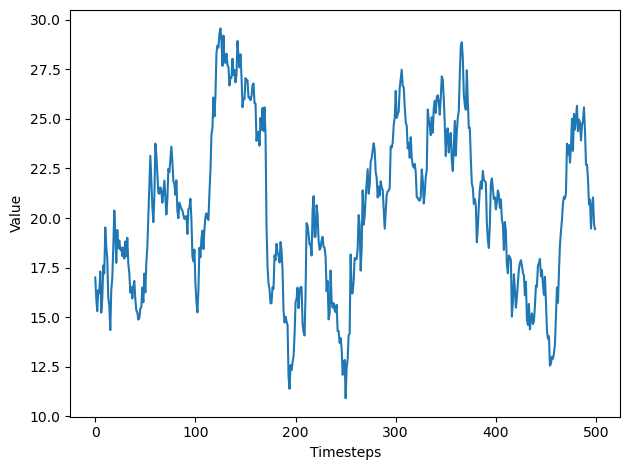

In [3]:
fig, ax = plt.subplots()

ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

### 3. 정상성 테스트 (ADF TEST로 확인)

ADF Statistic: -2.8452782121655225
p=value: 0.052091493734434426


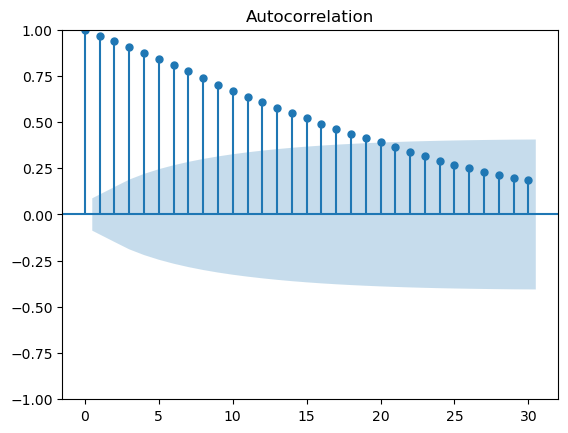

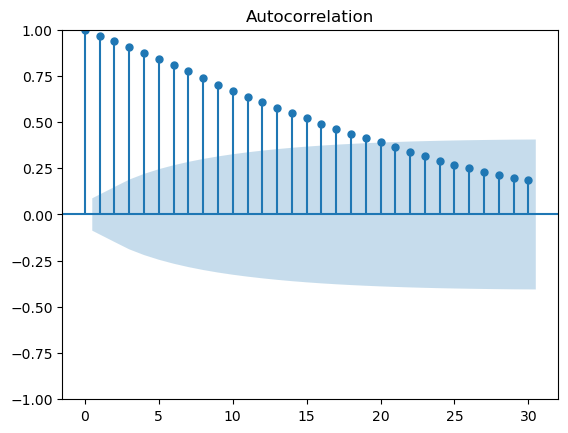

In [4]:
ADF_result = adfuller(random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p=value: {ADF_result[1]}')

# 도식화로 보다 확실히 확인
plot_acf(random_walk, lags=30)

### 4. 1차 차분 적용

In [5]:
diff_random_walk = np.diff(random_walk, n=1)

###  5.정상성 테스트 (ADF TEST로 확인)

ADF Statistic: -22.226081698863307
p=value: 0.0


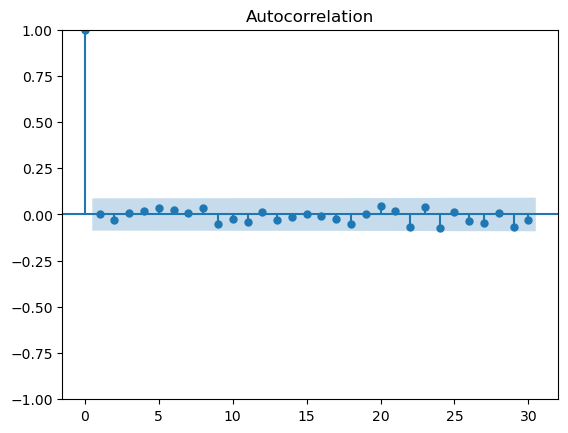

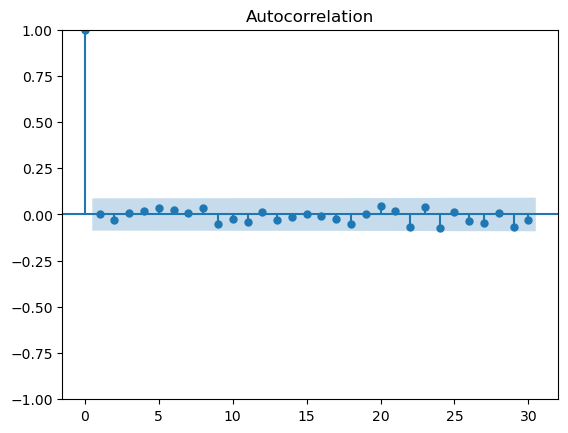

In [6]:
ADF_result = adfuller(diff_random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p=value: {ADF_result[1]}')

# 도식화로 보다 확실히 확인
plot_acf(diff_random_walk, lags=30)

### 6. 시뮬레이션된 확률보행 중 400/100 -> 훈련 집합 / 테스트 집합 분할

In [7]:
df = pd.DataFrame({'value': random_walk})
train = df[:400].copy()
test = df[400:].copy()

### 7. 다양한 단순한 예측 방법 적용 후 MSE 측정

In [8]:
# 과거 기간의 평균을 사용하여 예측하는 방법
mean = np.mean(train.value)
test.loc[:, 'pred_mean'] = mean

test.head()

,value,pred_mean
400,20.437354,20.823185
401,20.791403,20.823185
402,21.390390,20.823185
403,21.179130,20.823185
404,20.512321,20.823185


In [9]:
# 마지막으로 측정된 값으로 예측하는 방법
last_value = train.iloc[-1].value
test.loc[:, 'pred_last'] = last_value

test.head()

,value,pred_mean,pred_last
400,20.437354,20.823185,21.041052
401,20.791403,20.823185,21.041052
402,21.390390,20.823185,21.041052
403,21.179130,20.823185,21.041052
404,20.512321,20.823185,21.041052


In [10]:
# 표류 기법을 사용하는 방법
deltaX = 400-0
deltaY = last_value - steps[0]

drift = deltaY / deltaX

print(drift)


x_vals = np.arange(400, 500, 1)
pred_drift = drift * x_vals + steps[0]
test.loc[:, 'pred_drift'] = pred_drift
test.head()


0.010102629714173004


,value,pred_mean,pred_last,pred_drift
400,20.437354,20.823185,21.041052,21.041052
401,20.791403,20.823185,21.041052,21.051155
402,21.390390,20.823185,21.041052,21.061257
403,21.179130,20.823185,21.041052,21.071360
404,20.512321,20.823185,21.041052,21.081462


In [11]:
# 각 방법에 따른 MSE
mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last'])
mse_drift = mean_squared_error(test['value'], test['pred_drift'])

print(mse_mean, mse_last, mse_drift)

16.803516326574268 17.724012319340435 19.28348167112524


### 8. 예측값을 도식화한다

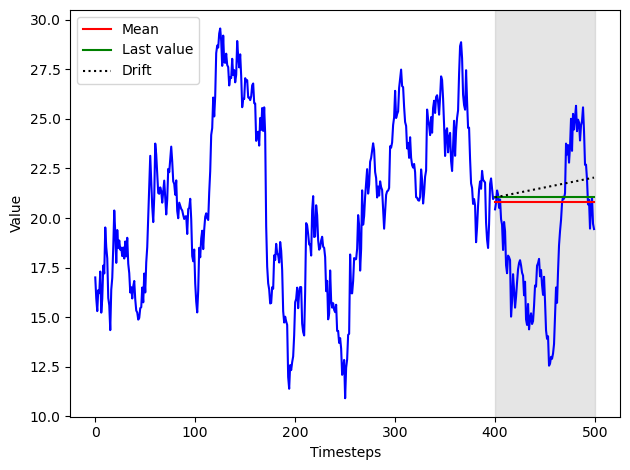

In [12]:
fig, ax = plt.subplots()

ax.plot(train.value, 'b-')
ax.plot(test['value'], 'b-')
ax.plot(test['pred_mean'], 'r-', label='Mean')
ax.plot(test['pred_last'], 'g-', label='Last value')
ax.plot(test['pred_drift'], 'k:', label='Drift')

ax.axvspan(400, 500, color='#808080', alpha = 0.2)
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

### 9. 테스트 집합에 대해 다음 시간 단계를 예측해보고 MSE를 측정한다.

In [13]:
# 다음 시간 관계 예측하는 방법
df_shift = df.shift(periods = 1)

df_shift.head()
 

,value
0,NaN
1,17.000000
2,15.936599
3,15.298523
4,16.360112


In [14]:
# MSE
mse_one_step = mean_squared_error(test['value'], df_shift[400:])
print(mse_one_step)

0.888661254054242


### 10. 예측값을 도식화한다

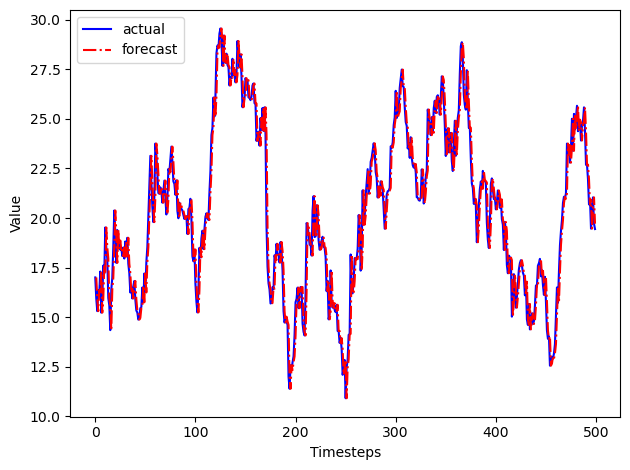

In [15]:
fig, ax = plt.subplots()

ax.plot(df, 'b-', label='actual')
ax.plot(df_shift, 'r-.', label='forecast')

ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

## 3.5.2. GOOGL의 일일 종가 예측하기

In [16]:
# 구글 일봉데이터 가져오기
goog = yf.Ticker('GOOGL')
data = goog.history(period="1y", start="2018-01-01", end="2018-12-31")
print(data)

                                Open       High        Low      Close  \
Date                                                                    
2018-01-02 00:00:00-05:00  52.400475  53.543012  52.400475  53.405170   
2018-01-03 00:00:00-05:00  53.441002  54.544229  53.416123  54.316319   
2018-01-04 00:00:00-05:00  54.593491  54.941327  54.452666  54.527306   
2018-01-05 00:00:00-05:00  54.909979  55.414069  54.827871  55.250351   
2018-01-08 00:00:00-05:00  55.285683  55.691743  55.235922  55.445419   
...                              ...        ...        ...        ...   
2018-12-21 00:00:00-05:00  51.356468  51.636627  48.826067  49.326672   
2018-12-24 00:00:00-05:00  48.981819  50.365204  48.650403  48.999237   
2018-12-26 00:00:00-05:00  49.662066  52.173060  49.396334  52.143204   
2018-12-27 00:00:00-05:00  51.065858  52.416399  50.110423  52.394505   
2018-12-28 00:00:00-05:00  52.722937  52.958311  51.852100  52.084988   

                              Volume  Dividends  S

### 1. 마지막 5일간의 데이터를 테스트 집합으로, 나머지는 훈련 집합

In [17]:
df = pd.DataFrame(data)
train = df[:-5].copy()
test = df[-5:].copy()


### 2. 단순한 예측 방법을 사용하여 5일간 종가 얘측 후 MSE 측정

In [18]:
# 과거 기간의 평균을 사용하여 예측하는 방법
mean = np.mean(train.Close)
test.loc[:, 'pred_mean_close'] = mean

In [19]:
# 마지막으로 측정된 값으로 예측하는 방법
last_close = train.iloc[-1].Close
# train.loc[:, 'pred_last_close'] = last_close
test.loc[:, 'pred_last_close'] = last_close

In [20]:
# 표류 기법을 사용하는 방법
deltaX = len(train) - 0
deltaY = last_close - train.iloc[0].Close

drift = deltaY / deltaX

x_vals = np.arange(len(train),len(train)+5 , 1)
pred_drift = drift * x_vals + train['Close'].iloc[0]
test.loc[:, 'pred_drift'] = pred_drift
test.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits,pred_mean_close,pred_last_close,pred_drift
Date,,,,,,,,,,
2018-12-21 00:00:00-05:00,51.356468,51.636627,48.826067,49.326672,104656000,0.0,0.0,55.949778,50.935478,50.935478
2018-12-24 00:00:00-05:00,48.981819,50.365204,48.650403,48.999237,36360000,0.0,0.0,55.949778,50.935478,50.925398
2018-12-26 00:00:00-05:00,49.662066,52.173060,49.396334,52.143204,46318000,0.0,0.0,55.949778,50.935478,50.915317
2018-12-27 00:00:00-05:00,51.065858,52.416399,50.110423,52.394505,45996000,0.0,0.0,55.949778,50.935478,50.905237
2018-12-28 00:00:00-05:00,52.722937,52.958311,51.852100,52.084988,34398000,0.0,0.0,55.949778,50.935478,50.895157


In [21]:
# 각 방법에 따른 MSE
mse_mean = mean_squared_error(test['Close'], test['pred_mean_close'])
mse_last = mean_squared_error(test['Close'], test['pred_last_close'])
mse_drift = mean_squared_error(test['Close'], test['pred_drift'])

print(mse_mean, mse_last, mse_drift)

26.848430161360774 2.249203844679869 2.2879347972189104


### 3. 예측값 도식화

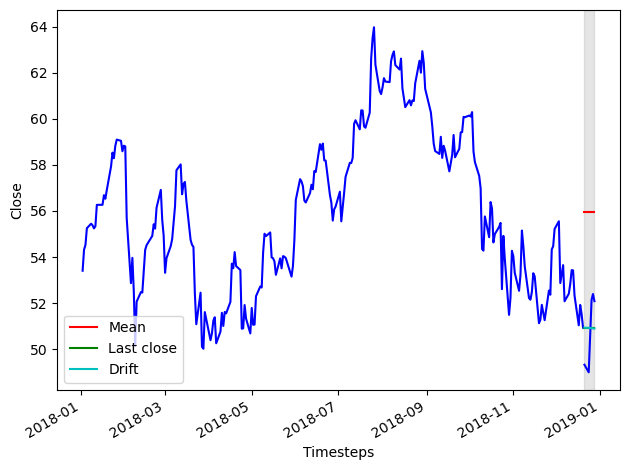

In [22]:
fig, ax = plt.subplots()

ax.plot(train['Close'], 'b-')
ax.plot(test['Close'], 'b-')
ax.plot(test['pred_mean_close'], 'r-', label='Mean')
ax.plot(test['pred_last_close'], 'g-', label='Last close')
ax.plot(test['pred_drift'], 'c-', label='Drift')

ax.axvspan(test.index[-5], test.index[-1], color='#808080', alpha = 0.2)
ax.legend(loc=3)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Close')

fig.autofmt_xdate()
plt.tight_layout()

### 4. 테스트 집합에 대해 다음 시간 단계를 예측하고 MSE를 측정한다.

In [23]:
# 다음 시간 관계 예측하는 방법
df_shift = df.shift(periods = 1)
df_shift.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-01-02 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03 00:00:00-05:00,52.400475,53.543012,52.400475,53.405170,31766000.0,0.0,0.0
2018-01-04 00:00:00-05:00,53.441002,54.544229,53.416123,54.316319,31318000.0,0.0,0.0
2018-01-05 00:00:00-05:00,54.593491,54.941327,54.452666,54.527306,26052000.0,0.0,0.0
2018-01-08 00:00:00-05:00,54.909979,55.414069,54.827871,55.250351,30250000.0,0.0,0.0


In [24]:
# MSE
mse_one_step = mean_squared_error(test['Close'], df_shift.Close[-5:])
print(mse_one_step)

2.5477902704820736


### 5. 에측값을 도식화한다

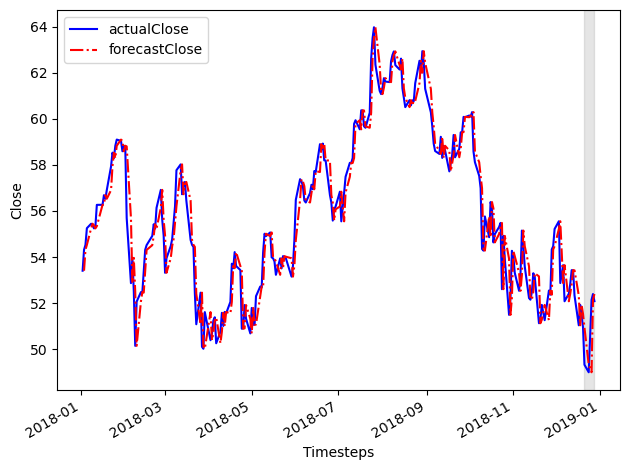

In [25]:
fig, ax = plt.subplots()

ax.plot(df.Close, 'b-', label='actualClose')
ax.plot(df_shift.Close, 'r-.', label='forecastClose')

ax.axvspan(test.index[-5], test.index[-1], color='#808080', alpha = 0.2)
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Close')

fig.autofmt_xdate()
plt.tight_layout()

In [26]:
## 

## 3.5.3 직접 선택한 종목의 일일 종가 예측하기

### 1. 선택한 주식의 일일 종가 도식화

In [27]:
# 애플 일봉데이터 가져오기
aapl = yf.Ticker('AAPL')
data = aapl.history(period="1y", start="2022-01-01", end="2022-12-31")
print(data)

                                 Open        High         Low       Close  \
Date                                                                        
2022-01-03 00:00:00-05:00  174.771775  179.734931  174.653844  178.879883   
2022-01-04 00:00:00-05:00  179.489254  179.793920  176.039607  176.609634   
2022-01-05 00:00:00-05:00  176.521197  177.071564  171.636666  171.911850   
2022-01-06 00:00:00-05:00  169.730027  172.285320  168.688259  169.042068   
2022-01-07 00:00:00-05:00  169.916756  171.145259  168.088742  169.209137   
...                               ...         ...         ...         ...   
2022-12-23 00:00:00-05:00  129.415284  130.898044  128.149997  130.344482   
2022-12-27 00:00:00-05:00  129.869997  129.899651  127.240566  128.535507   
2022-12-28 00:00:00-05:00  128.179661  129.524031  124.423341  124.591385   
2022-12-29 00:00:00-05:00  126.518978  128.980357  126.261971  128.120361   
2022-12-30 00:00:00-05:00  126.934126  128.456420  125.965387  128.436646   

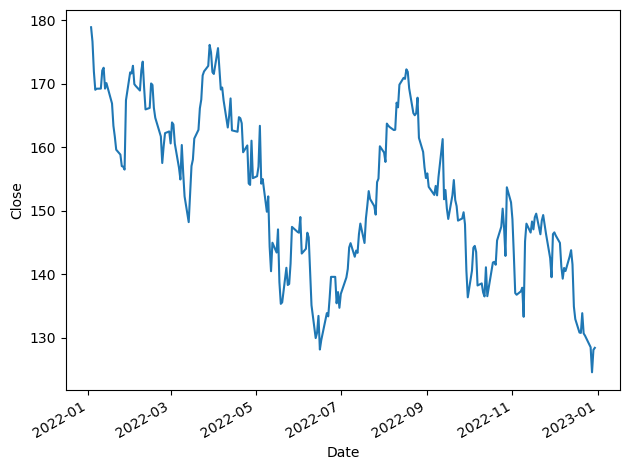

In [28]:
fig, ax = plt.subplots()

ax.plot(data['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Close')

fig.autofmt_xdate()
plt.tight_layout()

### 2. 확률보행인지 아닌지 확인한다.

ADF Statistic: -2.196121104483976
p=value: 0.20765628319630702


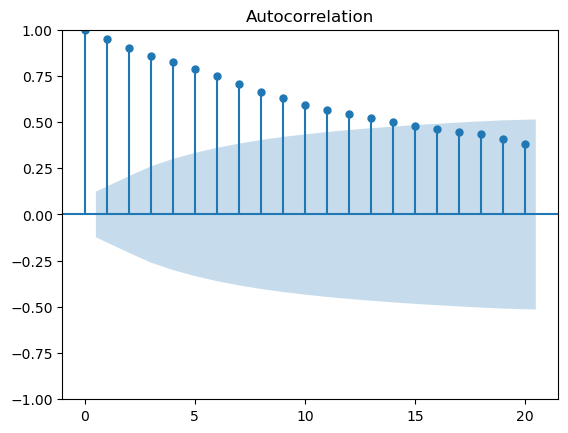

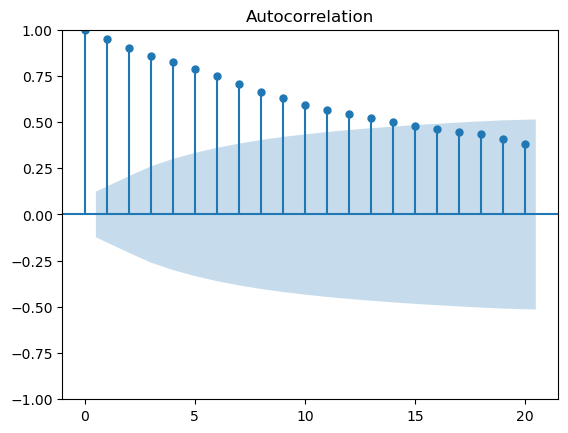

In [29]:
ADF_result = adfuller(data['Close'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p=value: {ADF_result[1]}')

plot_acf(data['Close'], lags=20)

### 3. 확률보행이 아니라면 이유를 설명해보자.

ADF_result[0], ADF통계는 절댓값이 크지 않은 음수이다. 
또한, ADF_result[1]인, p-값이 0.05보다 크다. 즉 단위근이다.
ACF 도식화를 확인해봐도 지연 증가에 따라 자기상관계수가 감소하고 있기 때문에 
확률보행이 아니라는 것을 확인할 수 있다.


### 4. 마지막 5일간의 데이터를 테스트 집합으로, 나머지는 훈련 집합

In [30]:
df = pd.DataFrame(data)
train = df[:-5].copy()
test = df[-5:].copy()


### 5. 단순한 예측 방법을 사용하여 5일간 종가 얘측 후 MSE 측정

In [31]:
# 과거 기간의 평균을 사용하여 예측하는 방법
mean = np.mean(train['Close'])
test.loc[:, 'pred_mean_close'] = mean

In [32]:
# 마지막으로 측정된 값으로 예측하는 방법
last_close = train.iloc[-1].Close
test.loc[:, 'pred_last_close'] = last_close

In [33]:
# 표류 기법을 사용하는 방법
deltaX = len(train) - 0
deltaY = last_close - train.iloc[0].Close

drift = deltaY / deltaX

x_vals = np.arange(len(train),len(train)+5 , 1)
pred_drift = drift * x_vals + train['Close'].iloc[0]
test.loc[:, 'pred_drift'] = pred_drift
test.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits,pred_mean_close,pred_last_close,pred_drift
Date,,,,,,,,,,
2022-12-23 00:00:00-05:00,129.415284,130.898044,128.149997,130.344482,63814900,0.0,0.0,153.107593,130.710236,130.710236
2022-12-27 00:00:00-05:00,129.869997,129.899651,127.240566,128.535507,69007800,0.0,0.0,153.107593,130.710236,130.514424
2022-12-28 00:00:00-05:00,128.179661,129.524031,124.423341,124.591385,85438400,0.0,0.0,153.107593,130.710236,130.318612
2022-12-29 00:00:00-05:00,126.518978,128.980357,126.261971,128.120361,75703700,0.0,0.0,153.107593,130.710236,130.122801
2022-12-30 00:00:00-05:00,126.934126,128.456420,125.965387,128.436646,77034200,0.0,0.0,153.107593,130.710236,129.926989


In [34]:
# 각 방법에 따른 MSE
mse_mean = mean_squared_error(test['Close'], test['pred_mean_close'])
mse_last = mean_squared_error(test['Close'], test['pred_last_close'])
mse_drift = mean_squared_error(test['Close'], test['pred_drift'])

print(mse_mean, mse_last, mse_drift)

633.627616224797 10.836042713280767 8.616382287214854


### 6. 예측값 도식화

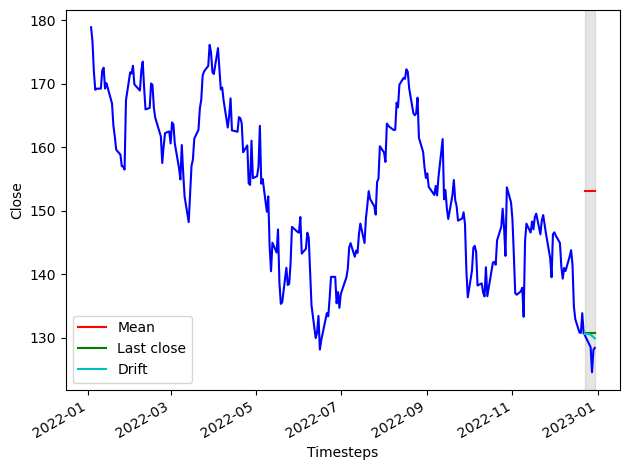

In [35]:
fig, ax = plt.subplots()

ax.plot(train['Close'], 'b-')
ax.plot(test['Close'], 'b-')
ax.plot(test['pred_mean_close'], 'r-', label='Mean')
ax.plot(test['pred_last_close'], 'g-', label='Last close')
ax.plot(test['pred_drift'], 'c-', label='Drift')

ax.axvspan(test.index[-5], test.index[-1], color='#808080', alpha = 0.2)
ax.legend(loc=3)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Close')

fig.autofmt_xdate()
plt.tight_layout()

### 7. 테스트 집합에 대해 다음 시간 단계를 예측하고 MSE를 측정한다.

In [36]:
# 다음 시간 관계 예측하는 방법
df_shift = df.shift(periods = 1)

df_shift.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-01-03 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04 00:00:00-05:00,174.771775,179.734931,174.653844,178.879883,104487900.0,0.0,0.0
2022-01-05 00:00:00-05:00,179.489254,179.793920,176.039607,176.609634,99310400.0,0.0,0.0
2022-01-06 00:00:00-05:00,176.521197,177.071564,171.636666,171.911850,94537600.0,0.0,0.0
2022-01-07 00:00:00-05:00,169.730027,172.285320,168.688259,169.042068,96904000.0,0.0,0.0


In [37]:
# MSE
mse_one_step = mean_squared_error(test['Close'], df_shift.Close[-5:])
print(mse_one_step)

6.303195592109114


### 8. 에측값을 도식화한다

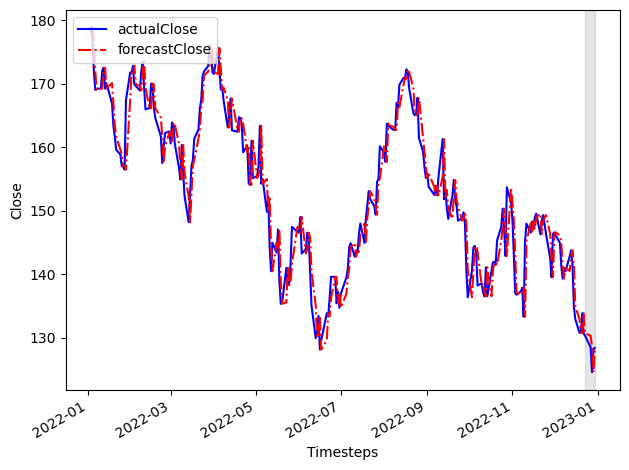

In [38]:
fig, ax = plt.subplots()

ax.plot(df.Close, 'b-', label='actualClose')
ax.plot(df_shift.Close, 'r-.', label='forecastClose')

ax.axvspan(test.index[-5], test.index[-1], color='#808080', alpha = 0.2)
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Close')

fig.autofmt_xdate()
plt.tight_layout()